<a href="https://colab.research.google.com/github/edwinb-ai/segnet/blob/master/ejemplos/pretrained_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install -U git+https://github.com/qubvel/segmentation_models.git

  Cloning https://github.com/qubvel/segmentation_models.git to /tmp/pip-req-build-x214vlmx
  Running command git clone -q https://github.com/qubvel/segmentation_models.git /tmp/pip-req-build-x214vlmx
  Running command git submodule update --init --recursive -q
  Created wheel for segmentation-models: filename=segmentation_models-1.0.0b1-cp36-none-any.whl size=33615 sha256=762bca5d8ca988752c1aabfb11b7de4a53d6998d0637d625362ed72df3679f43
  Stored in directory: /tmp/pip-ephem-wheel-cache-jzd7i2cl/wheels/d6/18/c4/340b3ee7253119ec907ec8cf93bd2c572ee9a75eedb183b2f8
Successfully built segmentation-models
  Found existing installation: segmentation-models 1.0.0b1
    Uninstalling segmentation-models-1.0.0b1:
      Successfully uninstalled segmentation-models-1.0.0b1


In [0]:
import segmentation_models as sm
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import glob
from skimage import io
import numpy as np
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [0]:
epochs = 10
batch_size = 32

In [0]:
path_train = "/content/drive/My Drive/Colab Notebooks/DRIVE/training/images/"
path_test = "/content/drive/My Drive/Colab Notebooks/DRIVE/test/images/"
path_mask = "/content/drive/My Drive/Colab Notebooks/DRIVE/training/1st_manual/"
path_mask_test = "/content/drive/My Drive/Colab Notebooks/DRIVE/test/1st_manual/"

X = []
y = []
X_val = []
y_val = []

#TODO: Importar las imágenes en orden!!!

for i in range(21, 41):
    img_name = f"{i}_training.tif"
    X.append(io.imread(path_train + img_name))
    
    mask_name = f"{i}_manual1.gif"
    y.append(io.imread(path_mask + mask_name))
    
for i in range(1, 21):
    img_name = f"{i:02d}_test.tif"
    X_val.append(io.imread(path_test + img_name))
    
    mask_name = f"{i:02d}_manual1.gif"
    y_val.append(io.imread(path_mask_test + mask_name))
    
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)
X_val = np.array(X_val, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)

/usr/local/lib/python3.6/dist-packages/skimage/external/tifffile/tifffile.py:2616: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


In [0]:
print(X.shape, y.shape)
print(X_val.shape, y_val.shape)

(20, 584, 565, 3) (20, 584, 565)
(20, 584, 565, 3) (20, 584, 565)


In [0]:
y = y[:, :, :, None]
y_val = y_val[:, :, :, None]

In [0]:
print(X.shape, y.shape)

(20, 584, 565, 3) (20, 584, 565, 1)


In [0]:
X /= 255
y /= 255
X_val /= 255
y_val /=255

In [0]:
%run "/content/drive/My Drive/Colab Notebooks/preprocesamiento.py"

In [0]:
X_test, y_test = muchas_imagenes_en_partes(X, y, num_partes=5)
X_val_patches, y_val_patches = muchas_imagenes_en_partes(X_val, y_val,
                                                        num_partes=5)

In [0]:
print(X_test.shape, y_test.shape)

(100, 128, 128, 3) (100, 128, 128, 1)


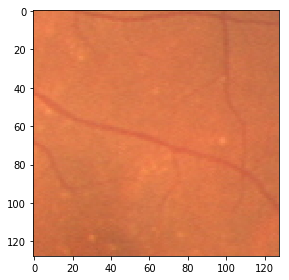

In [0]:
io.imshow(X_test[0])

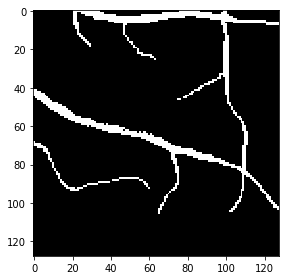

In [0]:
io.imshow(y_test[0, :, :, 0])

In [0]:
transformaciones = dict(
        rotation_range=20.0,
        height_shift_range=0.05,
        width_shift_range=0.05,
        shear_range=40,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode="constant",
    )

In [0]:
entrenamiento = aumentar_imagenes_mascaras(X_test, y_test, 
                                           transformaciones=transformaciones,
                                           batch_size=batch_size)

In [0]:
model = sm.Unet("efficientnetb0",
                encoder_weights="imagenet",
                encoder_freeze=True)

W0830 18:14:26.183936 139774111115136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0830 18:14:26.205790 139774111115136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0830 18:14:26.210030 139774111115136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4479: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0830 18:14:26.235196 139774111115136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0830 18:14:26.236287

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 3 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 3 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [0]:
model.compile(
  optimizer=SGD(1e-2, momentum=0.99),
    loss="binary_crossentropy",
    metrics=[sm.metrics.iou_score, sm.metrics.f1_score],
)

W0830 18:14:37.164410 139774111115136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0830 18:14:37.176156 139774111115136 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
model_path = "/content/drive/My Drive/Colab Notebooks/segmentacion-drive/pretrained.h5"
best_model = ModelCheckpoint(model_path,
                             monitor="val_f1-score",
                            verbose=1,
                             mode="max",
                            save_best_only=True,)
lr_reduce = ReduceLROnPlateau(monitor="val_loss",
                              patience=2,
                              verbose=1,
                              mode="min",)

In [0]:
history = model.fit_generator(
    entrenamiento,
    epochs=epochs,
    steps_per_epoch=1000,
    validation_data=(X_val_patches, y_val_patches),
    verbose=1,
    callbacks=[best_model, lr_reduce]
)

Epoch 1/10
1000/1000 [==============================] - 289s 289ms/step - loss: 0.1518 - iou_score: 0.4310 - f1-score: 0.5942 - val_loss: 0.1285 - val_iou_score: 0.5049 - val_f1-score: 0.6701

Epoch 00001: val_f1-score improved from -inf to 0.67009, saving model to /content/drive/My Drive/Colab Notebooks/segmentacion-drive/pretrained.h5
Epoch 2/10
1000/1000 [==============================] - 278s 278ms/step - loss: 0.1180 - iou_score: 0.5105 - f1-score: 0.6753 - val_loss: 0.1205 - val_iou_score: 0.5422 - val_f1-score: 0.7023

Epoch 00002: val_f1-score improved from 0.67009 to 0.70234, saving model to /content/drive/My Drive/Colab Notebooks/segmentacion-drive/pretrained.h5
Epoch 3/10
1000/1000 [==============================] - 277s 277ms/step - loss: 0.1110 - iou_score: 0.5296 - f1-score: 0.6918 - val_loss: 0.1192 - val_iou_score: 0.5487 - val_f1-score: 0.7078

Epoch 00003: val_f1-score improved from 0.70234 to 0.70776, saving model to /content/drive/My Drive/Colab Notebooks/segmentaci

In [0]:
model.load_weights(model_path)
result = model.predict(X_val_patches)

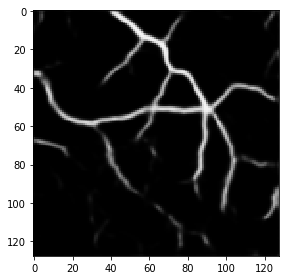

In [0]:
io.imshow(result[0, :, :, 0])

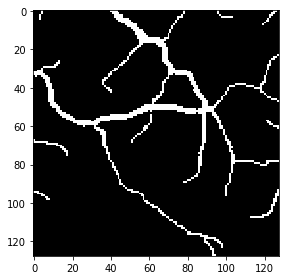

In [0]:
io.imshow(y_val_patches[0, :, :, 0])